# XGBoost Regression Analysis of Wind Turbine Data

1. [Imports.](#Cell1)
1. [Load preprocessed training data set and split it into training and testing subsets.](#Cell2)
1. [Find out what default hyperparameters XGBoost suggests for this problem.](#Cell3)
1. [Set default hyperparameter values, then monitor model performance (rmse) as trees are added.](#Cell4)
1. [Tune the number and size of trees using cross-validation.](#Cell5)
1. [Tune the learning rate and the number of trees using cross-validation.](#Cell6)
1. [Tune the row subsampling.](#Cell7)
1. [Tune the column subsampling by tree.](#Cell8)
1. [Tune the column subsampling by split.](#Cell9)
1. [Tune the alpha regularization parameter.](#Cell10)
1. [Tune the lambda regularization parameter.](#Cell11)
1. [Create separate models for each of the ten turbines, using cross-validation.](#Cell12)
1. [Retrieve from disk the regressor model that was trained on the training subsample only.](#Cell13)
1. [Test the fitted models on the testing subset.](#Cell14)
1. [Plot feature importances averaged over all turbines.](#Cell15)
1. [Refit model with final settings to entire training data set and save fitted model to disk.](#Cell16)
1. [Retrieve trained model from disk. Only run this cell if previous one wasn't run.](#Cell17)
1. [Prepare the test data set in the same way as the training set, make predictions, and create output csv file.](#Cell18)

<a id='Cell1'></a>

In [1]:
'''
Imports.
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.externals import joblib
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from time import strftime
from datetime import datetime
from operator import itemgetter
import csv

<a id='Cell2'></a>

In [3]:
'''
Load preprocessed training data set and split it into training and testing subsets.
'''
# Set input parameters
N_train           = 10000 # Size of training subset within training data set
rmws              = 3     # Rolling mean window size
nturbines         = 10    # Number of different turbines in data set
wind_measurements = [1, 2, 3, 4, 6, 7, 9, 10]
gamlss            = False  # Flag to enable analysis on the same predictors as the gamlss analysis

# Select appropriate training data file
if rmws<=1:
    rm = "_"
    TrainingDataFile = "data/Train_pp_2017_02_27_18_37_05.pkl" # No rolling means
elif rmws==2:
    rm = "_rm2_"
    TrainingDataFile = "data/Train_pp_2017_03_11_22_52_56.pkl" # Rolling means over 2 measurements
elif rmws==3:
    rm = "_rm3_"
#    TrainingDataFile = "data/Train_pp_2017_03_09_17_07_30.pkl" # With rolling means over 3 measurements
#    TrainingDataFile = "data/Train_pp_2017_03_10_15_37_41.pkl" # Rolling means over 3 measurements
    TrainingDataFile = "data/Train_pp_2017_03_27_17_43_43.pkl" # Rolling means over 3 measurements, dups removed
elif rmws==4:
    rm = "_rm4_"
    TrainingDataFile = "data/Train_pp_2017_03_11_02_06_50.pkl" # Rolling means over 4 measurements
else:
    print("Invalid rolling mean window size: {0}".format(rmws))
    
# Load data
df0 = pd.read_pickle(TrainingDataFile)
print('Shape of loaded data frame: {0}'.format(df0.shape))

# Rename dataframe columns and make lists with the new predictor and target labels
predictors  = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]!='TARGETVAR']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
targets     = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]=='TARGETVAR']
df0.columns = targets+predictors

# If desired, transform predictor variables to be the same as in the gamlss analysis
U10label  = ["U10"+rm+str(i) for i in wind_measurements]
U100label = ["U100"+rm+str(i) for i in wind_measurements]
V10label  = ["V10"+rm+str(i) for i in wind_measurements]
V100label = ["V100"+rm+str(i) for i in wind_measurements]
H10label  = ["H10"+rm+str(i) for i in wind_measurements]
H100label = ["H100"+rm+str(i) for i in wind_measurements]
if gamlss:
    for i in range(0,len(wind_measurements)):
        df0[H10label[i]]  = np.sqrt(df0[U10label[i]]**2 + df0[V10label[i]]**2)
        df0[H100label[i]] = np.sqrt(df0[U100label[i]]**2 + df0[V100label[i]]**2)
    df0.drop(U10label,  1, inplace=True)
    df0.drop(U100label, 1, inplace=True)
    df0.drop(V10label,  1, inplace=True)
    df0.drop(V100label, 1, inplace=True)
    df0.drop(["YEAR", "DAYOFYEAR", "HOUR"], 1, inplace=True)
    predictors = [item for item in df0.columns.values if item[:9]!='TARGETVAR']

# Split data set into training and testing subsets
df0_train, df0_test  = train_test_split(df0, train_size=N_train, random_state=0)

print('Shape of df0_train:         {0}'.format(df0_train.shape))
print('Shape of df0_test:          {0}'.format(df0_test.shape))
print('\nPredictor variables: {0}'.format(predictors))

Shape of loaded data frame: (13871, 45)
Shape of df0_train:         (10000, 45)
Shape of df0_test:          (3871, 45)

Predictor variables: ['U10_rm3_1', 'U100_rm3_1', 'V10_rm3_1', 'V100_rm3_1', 'U10_rm3_2', 'U100_rm3_2', 'V10_rm3_2', 'V100_rm3_2', 'U10_rm3_3', 'U100_rm3_3', 'V10_rm3_3', 'V100_rm3_3', 'U10_rm3_4', 'U100_rm3_4', 'V10_rm3_4', 'V100_rm3_4', 'U10_rm3_6', 'U100_rm3_6', 'V10_rm3_6', 'V100_rm3_6', 'U10_rm3_7', 'U100_rm3_7', 'V10_rm3_7', 'V100_rm3_7', 'U10_rm3_9', 'U100_rm3_9', 'V10_rm3_9', 'V100_rm3_9', 'U10_rm3_10', 'U100_rm3_10', 'V10_rm3_10', 'V100_rm3_10', 'YEAR', 'DAYOFYEAR', 'HOUR']


## Explore parameter space

<a id='Cell3'></a>

In [12]:
'''
Find out what default hyperparameters XGBoost suggests for this problem.
'''
# Select a turbine for exploration
target = targets[8]

# Fit default model to training data to figure out what the XGB defaults are.
xgb1     = XGBRegressor()
eval_set = [(df0_train[predictors], df0_train[target]), (df0_test[predictors], df0_test[target])]
xgb1.fit(df0_train[predictors], df0_train[target], eval_metric=["rmse"], eval_set=eval_set, verbose=False)
print('\nDefault XGB model: {0}'.format(xgb1))


Default XGB model: XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


<a id='Cell4'></a>

CPU times: user 44.9 s, sys: 445 ms, total: 45.3 s
Wall time: 47 s
Algorithm: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)
RMSE on Test Set at Best Iteration:  0.137373, Number of Trees: 999
RMSE on Test Set at Final Iteration: 0.137372717741, Number of Trees: 1000


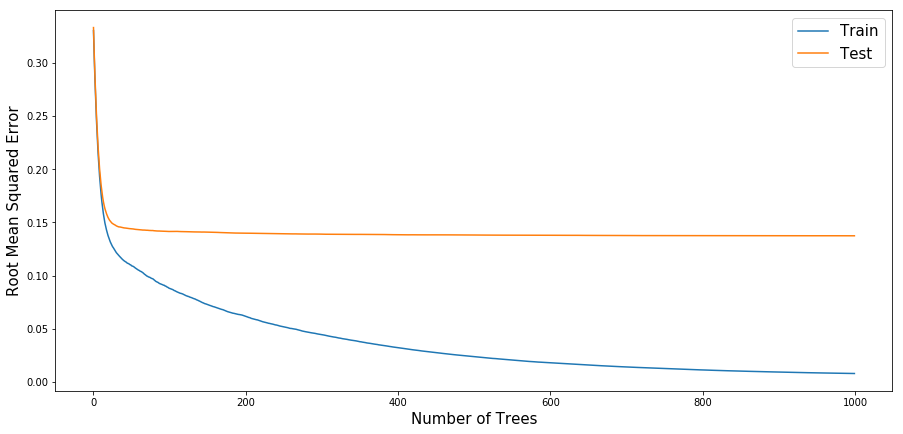

In [13]:
'''
Set default hyperparameter values, then monitor model performance (rmse) as trees are added.
'''
%matplotlib inline

defaults = {'objective': 'reg:linear', 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1, 
            'subsample': 0.8, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 
            'reg_alpha': 0.1, 'reg_lambda': 10.0, 
            'seed': 0, 'nthread': -1, 'silent': True}

target = targets[8]

# Fit model to training data
xgb1     = XGBRegressor(**defaults)
eval_set = [(df0_train[predictors], df0_train[target]), 
            (df0_test[predictors], df0_test[target])]
%time xgb1.fit(df0_train[predictors], df0_train[target], eval_metric=["rmse"], eval_set=eval_set, verbose=False)

# Make predictions for test data
df0_test_predictions = xgb1.predict(df0_test[predictors])

# Retrieve performance metrics
results             = xgb1.evals_result()
min_index, min_rmse = min(enumerate(results['validation_1']['rmse']), key=itemgetter(1))
n_trees_best        = min_index + 1
rmse_test           = np.sqrt(mean_squared_error(df0_test[target].values, df0_test_predictions))
n_trees_final       = len(results['validation_1']['rmse'])
print('Algorithm: {0}'.format(xgb1))
print("RMSE on Test Set at Best Iteration:  {0}, Number of Trees: {1}".format(min_rmse, n_trees_best))
print("RMSE on Test Set at Final Iteration: {0}, Number of Trees: {1}".format(rmse_test, n_trees_final))

#  Plot learning curves
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.plot(x_axis, results['validation_0']['rmse'], label='Train')
axis.plot(x_axis, results['validation_1']['rmse'], label='Test')
axis.legend(fontsize=15)
axis.set_xlabel('Number of Trees', fontsize=15)
axis.set_ylabel('Root Mean Squared Error', fontsize=15)
plt.show()

<a id='Cell5'></a>

CPU times: user 971 ms, sys: 144 ms, total: 1.12 s
Wall time: 7min 27s

Best score: 0.0203739940066, using {'n_estimators': 500, 'max_depth': 10}

0.0218059746427 +/- 0.00167794197165, with {'n_estimators': 350, 'max_depth': 6}
0.0217683863792 +/- 0.00168925293085, with {'n_estimators': 400, 'max_depth': 6}
0.0217570214609 +/- 0.00167449449751, with {'n_estimators': 450, 'max_depth': 6}
0.0217273489523 +/- 0.00166950560618, with {'n_estimators': 500, 'max_depth': 6}
0.020950413308 +/- 0.0015189400417, with {'n_estimators': 350, 'max_depth': 8}
0.0208995100737 +/- 0.00151916148876, with {'n_estimators': 400, 'max_depth': 8}
0.0208377231247 +/- 0.0015258677266, with {'n_estimators': 450, 'max_depth': 8}
0.020807342847 +/- 0.00151063686214, with {'n_estimators': 500, 'max_depth': 8}
0.0204535104368 +/- 0.00145376820451, with {'n_estimators': 350, 'max_depth': 10}
0.0204133149767 +/- 0.00144248385862, with {'n_estimators': 400, 'max_depth': 10}
0.0203917737094 +/- 0.00144324987607, with {'

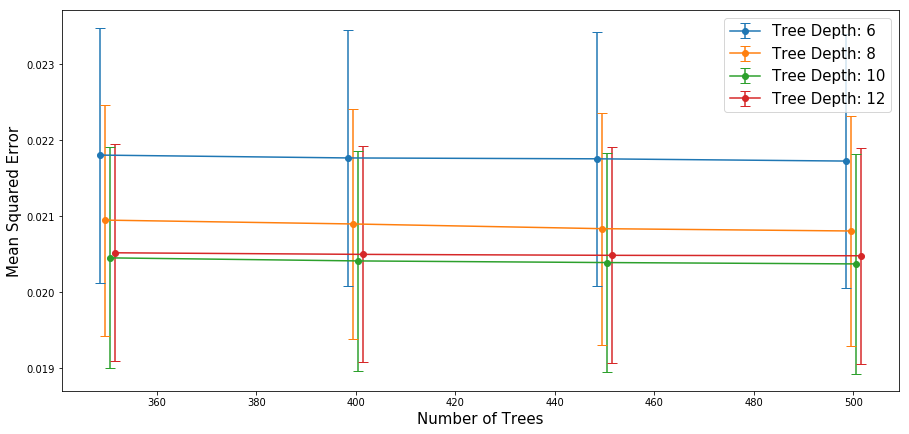

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.8, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.8, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 10}


In [14]:
'''
Tune the number and size of trees using cross-validation.
'''
# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'n_estimators': [350, 400, 450, 500], 'max_depth': [6, 8, 10, 12]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(-mean, stdev, param))
        
# Plot results (flip the score signs so we have mse instead of -mse).
n_xval    = len(searchGrid['n_estimators'])
n_yval    = len(searchGrid['max_depth'])
scores    = -np.array(means).reshape(n_yval, n_xval)
escores   = np.array(stds).reshape(n_yval, n_xval)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x_offset = [-1.5, -0.5, 0.5, 1.5]
for i, value in enumerate(searchGrid['max_depth']):
    plt.errorbar(x_offset[i]+np.array(searchGrid['n_estimators']), scores[i], 
                 yerr=escores[i], fmt='-o', capsize=5, label='Tree Depth: '+str(value))
plt.legend(fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell6'></a>

CPU times: user 637 ms, sys: 95 ms, total: 732 ms
Wall time: 5min 14s

Best score: 0.0203739940066, using {'n_estimators': 500, 'learning_rate': 0.1}

0.0773040086021 +/- 0.00197594189395, with {'n_estimators': 350, 'learning_rate': 0.001}
0.0724076752405 +/- 0.00185522458363, with {'n_estimators': 400, 'learning_rate': 0.001}
0.0679638806531 +/- 0.00174175178845, with {'n_estimators': 450, 'learning_rate': 0.001}
0.0639281103305 +/- 0.00164467517353, with {'n_estimators': 500, 'learning_rate': 0.001}
0.0223015905823 +/- 0.00157816315002, with {'n_estimators': 350, 'learning_rate': 0.01}
0.0219978040384 +/- 0.00159743236675, with {'n_estimators': 400, 'learning_rate': 0.01}
0.0217864363221 +/- 0.00161075675363, with {'n_estimators': 450, 'learning_rate': 0.01}
0.0216270022025 +/- 0.00160740115494, with {'n_estimators': 500, 'learning_rate': 0.01}
0.0204535104368 +/- 0.00145376820451, with {'n_estimators': 350, 'learning_rate': 0.1}
0.0204133149767 +/- 0.00144248385862, with {'n_estimat

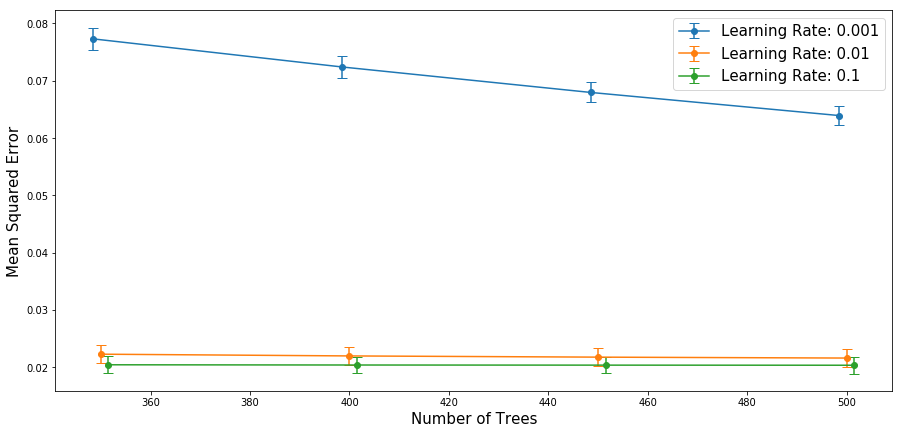

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.8, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.8, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 10}


In [15]:
'''
Tune the learning rate and the number of trees using cross-validation.
'''
# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'n_estimators': [350, 400, 450, 500], 'learning_rate': [0.001, 0.01, 0.1]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(-mean, stdev, param))
        
# Plot results (flip the score signs so we have mse instead of -mse).
n_xval    = len(searchGrid['n_estimators'])
n_yval    = len(searchGrid['learning_rate'])
scores    = -np.array(means).reshape(n_yval, n_xval)
escores   = np.array(stds).reshape(n_yval, n_xval)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x_offset  = [-1.5, 0.0, 1.5]
for i, value in enumerate(searchGrid['learning_rate']):
    plt.errorbar(x_offset[i]+np.array(searchGrid['n_estimators']), scores[i], 
                 yerr=escores[i], fmt='-o', capsize=5, label='Learning Rate: '+str(value))
plt.legend(fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell7'></a>

CPU times: user 554 ms, sys: 89.3 ms, total: 643 ms
Wall time: 4min 32s

Best score: 0.0203739940066, using {'subsample': 0.8}

0.0243841300023 +/- 0.00105592123353, with {'subsample': 0.1}
0.0225153217021 +/- 0.0012457302381, with {'subsample': 0.2}
0.0216234044167 +/- 0.00130860440077, with {'subsample': 0.3}
0.0209161284521 +/- 0.00155672461058, with {'subsample': 0.4}
0.020706128997 +/- 0.00147734019043, with {'subsample': 0.5}
0.0204254794203 +/- 0.00148834229636, with {'subsample': 0.6}
0.0203869153979 +/- 0.00157820632252, with {'subsample': 0.7}
0.0203739940066 +/- 0.00144218266019, with {'subsample': 0.8}
0.0203870305305 +/- 0.00152586207385, with {'subsample': 0.9}
0.0207204442857 +/- 0.00152223742945, with {'subsample': 1.0}


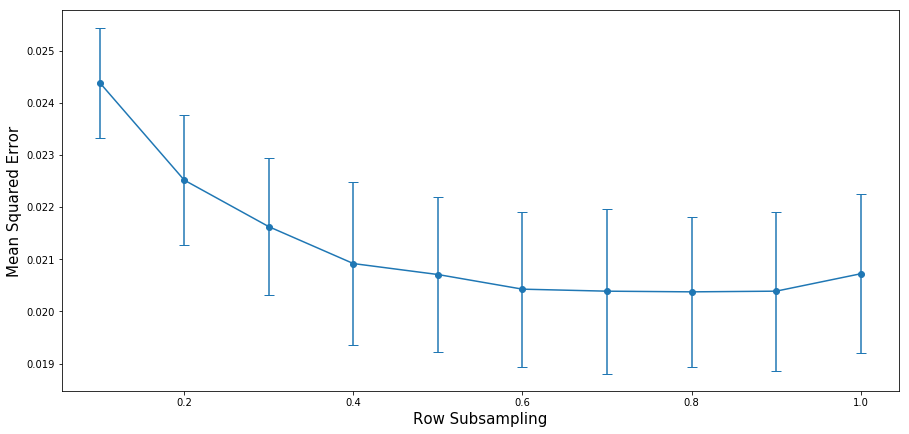

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.8, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.8, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 10}


In [16]:
'''
Tune the row subsampling.
'''
# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['subsample'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Row Subsampling', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell8'></a>

CPU times: user 398 ms, sys: 73.7 ms, total: 472 ms
Wall time: 3min 3s

Best score: 0.0203739940066, using {'colsample_bytree': 1.0}

0.0214388730698 +/- 0.00153727216058, with {'colsample_bytree': 0.4}
0.0207989055962 +/- 0.00145949419939, with {'colsample_bytree': 0.5}
0.0208761546842 +/- 0.00171875305395, with {'colsample_bytree': 0.6}
0.0207004196405 +/- 0.00162572667677, with {'colsample_bytree': 0.7}
0.0206634193894 +/- 0.00168650857012, with {'colsample_bytree': 0.8}
0.0205169063124 +/- 0.00156457761465, with {'colsample_bytree': 0.9}
0.0203739940066 +/- 0.00144218266019, with {'colsample_bytree': 1.0}


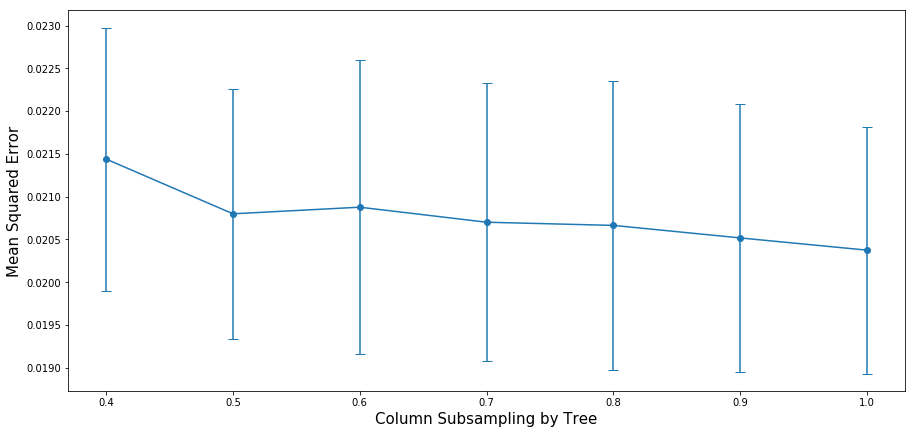

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.8, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.8, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 10}


In [19]:
'''
Tune the column subsampling by tree.
'''
# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['colsample_bytree'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Column Subsampling by Tree', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell9'></a>

CPU times: user 413 ms, sys: 74.5 ms, total: 487 ms
Wall time: 3min 54s

Best score: 0.0203593472266, using {'colsample_bylevel': 0.6}

0.0205344516184 +/- 0.00138438785494, with {'colsample_bylevel': 0.4}
0.0204287757042 +/- 0.00148370962862, with {'colsample_bylevel': 0.5}
0.0203593472266 +/- 0.00164606961543, with {'colsample_bylevel': 0.6}
0.0204497469824 +/- 0.00157762143453, with {'colsample_bylevel': 0.7}
0.0203739940066 +/- 0.00144218266019, with {'colsample_bylevel': 0.8}
0.020484866735 +/- 0.00163558724323, with {'colsample_bylevel': 0.9}
0.0206831236492 +/- 0.00159896372832, with {'colsample_bylevel': 1.0}


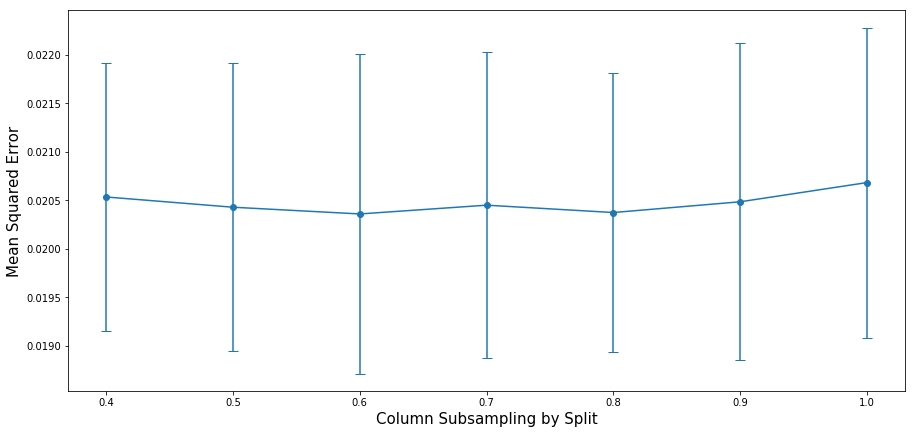

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.6, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.8, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 10}


In [20]:
'''
Tune the column subsampling by split.
'''
# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['colsample_bylevel'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Column Subsampling by Split', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell10'></a>

CPU times: user 461 ms, sys: 81.4 ms, total: 542 ms
Wall time: 3min 4s

Best score: 0.0203593472266, using {'reg_alpha': 0.1}

0.0204670390553 +/- 0.00164652890195, with {'reg_alpha': 1e-05}
0.0205064418492 +/- 0.00159336549842, with {'reg_alpha': 0.0001}
0.020540857984 +/- 0.00168134849819, with {'reg_alpha': 0.001}
0.0204831807485 +/- 0.00157525908011, with {'reg_alpha': 0.01}
0.0203593472266 +/- 0.00164606961543, with {'reg_alpha': 0.1}
0.0208483444233 +/- 0.00158219460627, with {'reg_alpha': 1.0}
0.0239400809156 +/- 0.00184449282637, with {'reg_alpha': 10.0}
0.0293628957067 +/- 0.00115614688889, with {'reg_alpha': 100.0}


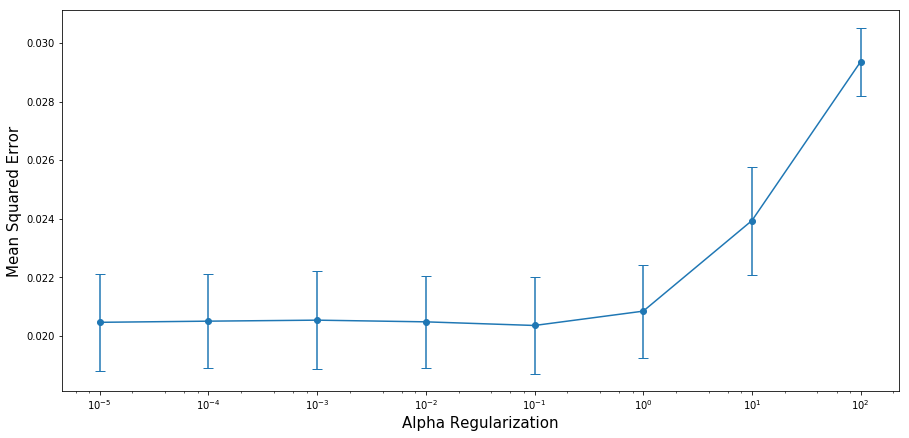

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.6, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.8, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 10}


In [21]:
'''
Tune the alpha regularization parameter.
'''
# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'reg_alpha': [1.0E-05, 1.0E-04, 1.0E-03, 1.0E-02, 0.1, 1.0, 10.0, 100.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['reg_alpha'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Alpha Regularization', fontsize=15)
axis.set_xscale('log')
axis.set_ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell11'></a>

CPU times: user 307 ms, sys: 64.5 ms, total: 372 ms
Wall time: 2min 19s

Best score: 0.0203593472266, using {'reg_lambda': 10.0}

0.0211288353982 +/- 0.00152453038294, with {'reg_lambda': 0.01}
0.0208685006316 +/- 0.00151111286748, with {'reg_lambda': 0.1}
0.0208468820636 +/- 0.00161148164923, with {'reg_lambda': 1.0}
0.0203593472266 +/- 0.00164606961543, with {'reg_lambda': 10.0}
0.020528230175 +/- 0.00154359567647, with {'reg_lambda': 100.0}


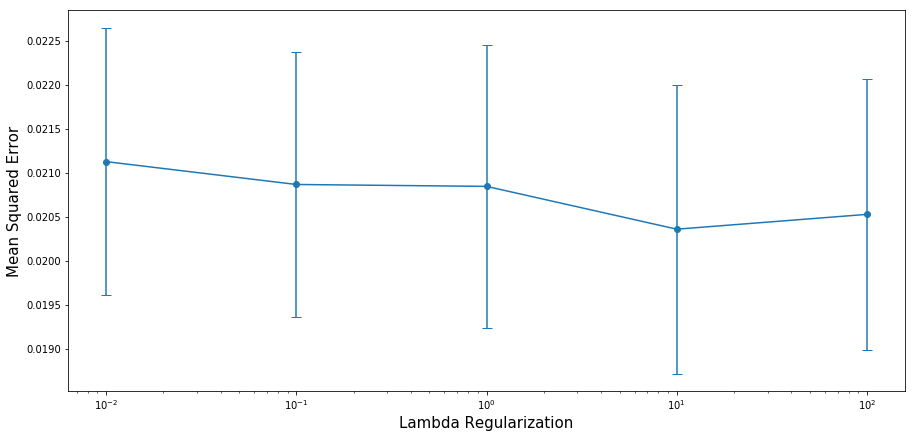

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.6, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.8, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 10}


In [22]:
'''
Tune the lambda regularization parameter.
'''
# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'reg_lambda': [0.01, 0.1, 1.0, 10.0, 100.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['reg_lambda'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Lambda Regularization', fontsize=15)
axis.set_xscale('log')
axis.set_ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

## Fit model to training subset of training sample and check properties on test subset.

<a id='Cell12'></a>

In [23]:
'''
Create separate models for each of the ten turbines, using cross-validation.
'''

defaults = {'objective': 'reg:linear', 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 
            'subsample': 0.8, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 
            'reg_alpha': 0.1, 'reg_lambda': 10.0, 
            'seed': 0, 'nthread': -1, 'silent': True}

searchGrids = [{'learning_rate': [0.1, 0.03, 0.01]}, 
               {'max_depth': [8, 10, 12]},
               {'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
               {'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
               {'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
               {'reg_alpha': [1.0E-04, 1.0E-03, 1.0E-02, 0.1, 1.0, 10.0]},
               {'reg_lambda': [0.01, 0.1, 1.0, 10.0, 100.0]}]

settings  = [defaults.copy() for _ in xrange(nturbines)]
xgbr_train_all = []
for target, setting in zip(targets, settings):
    print('\nFitting turbine {0}...'.format(target[10:]))
    for grid in searchGrids:
        gSearch = GridSearchCV(estimator=XGBRegressor(**setting), param_grid=grid, 
                               scoring='neg_mean_squared_error', n_jobs=-1, iid=True, cv=5, refit=False)
        gSearch.fit(df0_train[predictors], df0_train[target])
        setting.update(gSearch.best_params_)
        print('   Updated parameters: {0}, best score: {1}'.format(gSearch.best_params_, gSearch.best_score_))
    xgb1 = XGBRegressor(**setting)
    xgb1.fit(df0_train[predictors], df0_train[target], eval_metric=["rmse"], verbose=False)
    xgbr_train_all.append(xgb1)
    
fName = 'xgbr_train_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgbr_train_all, path_to_file)
print('\nExtreme gradient boosting regression model saved to {0}'.format(path_to_file))


Fitting turbine 1...
   Updated parameters: {'learning_rate': 0.1}, best score: -0.0143532347526
   Updated parameters: {'max_depth': 10}, best score: -0.0143532347526
   Updated parameters: {'subsample': 0.9}, best score: -0.0143062886458
   Updated parameters: {'colsample_bytree': 1.0}, best score: -0.0143062886458
   Updated parameters: {'colsample_bylevel': 0.4}, best score: -0.0142931351049
   Updated parameters: {'reg_alpha': 0.1}, best score: -0.0142931351049
   Updated parameters: {'reg_lambda': 10.0}, best score: -0.0142931351049

Fitting turbine 2...
   Updated parameters: {'learning_rate': 0.1}, best score: -0.0145273331752
   Updated parameters: {'max_depth': 12}, best score: -0.0144229449941
   Updated parameters: {'subsample': 0.7}, best score: -0.0143512062856
   Updated parameters: {'colsample_bytree': 1.0}, best score: -0.0143512062856
   Updated parameters: {'colsample_bylevel': 0.6}, best score: -0.0143512062856
   Updated parameters: {'reg_alpha': 0.1}, best score:

<a id='Cell13'></a>

In [4]:
'''
Retrieve from disk the regressor model that was trained on the training subsample only. 
'''

xgbr_found = True

try:
    xgbr_train_all
except:
#    fName = 'xgbr_train_2017_03_29_02_35_39' # rm=3, dups removed, (U,V,time) replaced by (H)
    fName = 'xgbr_train_2017_03_28_04_50_26' # rm=3, dups removed
#    fName = 'xgbr_train_2017_03_10_21_31_44' # rm=3
#    fName = 'xgbr_train_2017_03_11_06_51_08' # rm=4
#    fName = 'xgbr_train_2017_03_12_04_27_43' # rm=2
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbr_train_all = joblib.load(path_to_file)
    except:
        print('Error loading regressor model from {0}\n'.format(path_to_file))
        xgbr_found = False
    else:
        print('Regressor model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Regressor model already exists, not updated from file!\n')

if xgbr_found:
    for ind, xgbr in enumerate(xgbr_train_all):
        print('Turbine {0}:\nRegressor: {1}\n'.format(ind+1, xgbr))

Regressor model successfully loaded from fitted_models/xgbr_train_2017_03_28_04_50_26.model

Turbine 1:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 2:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 3:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.6, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=

<a id='Cell14'></a>

In [5]:
'''
Test the fitted models on the testing subset.
'''

Nturbines       = len(xgbr_train_all)
MSE_Train_Total = 0.0
MSE_Test_Total  = 0.0
for ind,xgb in enumerate(xgbr_train_all):
    
    target = 'TARGETVAR_'+str(ind+1)
    
    # Predict training set and testing set
    df0_train_predictions = xgb.predict(df0_train[predictors])
    df0_test_predictions  = xgb.predict(df0_test[predictors])
    df0_train_predictions = [min(max(x,0.0),1.0) for x in df0_train_predictions]
    df0_test_predictions  = [min(max(x,0.0),1.0) for x in df0_test_predictions]
    
    # Compute performance measures
    R2_Train  = r2_score(df0_train[target].values, df0_train_predictions)
    R2_Test   = r2_score(df0_test[target].values, df0_test_predictions)
    MSE_Train = mean_squared_error(df0_train[target].values, df0_train_predictions)
    MSE_Test  = mean_squared_error(df0_test[target].values, df0_test_predictions)

    # Compute confusion matrix for classifying zero turbine output
    cm = confusion_matrix([1 if v==0.0 else 0 for v in df0_test[target]], 
                          [1 if v==0.0 else 0 for v in df0_test_predictions])
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    
    # Print model report
    print('\nModel Report for Turbine {0}'.format(ind+1))
    print('On training set: R^2 =  {0}'.format(R2_Train))
    print('                 RMSE = {0}'.format(np.sqrt(MSE_Train)))
    print('On testing set:  R^2 =  {0}'.format(R2_Test))
    print('                 RMSE = {0}'.format(np.sqrt(MSE_Test)))
    print('                 Confusion Matrix: tp = {0}, fn = {1}, fp = {2}, tn = {3}'.format(tp, fn, fp, tn))
    MSE_Train_Total += MSE_Train
    MSE_Test_Total  += MSE_Test
print('\nTotal RMSE on training set: {0}'.format(np.sqrt(MSE_Train_Total/Nturbines)))
print('Total RMSE on testing set:  {0}'.format(np.sqrt(MSE_Test_Total/Nturbines)))


Model Report for Turbine 1
On training set: R^2 =  0.999044811835
                 RMSE = 0.00854779788101
On testing set:  R^2 =  0.900024308187
                 RMSE = 0.0890802321735
                 Confusion Matrix: tp = 81, fn = 303, fp = 22, tn = 3465

Model Report for Turbine 2
On training set: R^2 =  0.998989465439
                 RMSE = 0.00825388974475
On testing set:  R^2 =  0.888882256233
                 RMSE = 0.087955012881
                 Confusion Matrix: tp = 13, fn = 91, fp = 8, tn = 3759

Model Report for Turbine 3
On training set: R^2 =  0.999222155108
                 RMSE = 0.00831657416712
On testing set:  R^2 =  0.89121571736
                 RMSE = 0.0986888085355
                 Confusion Matrix: tp = 52, fn = 210, fp = 18, tn = 3591

Model Report for Turbine 4
On training set: R^2 =  0.996593844974
                 RMSE = 0.0187826964325
On testing set:  R^2 =  0.86744253388
                 RMSE = 0.119196213903
                 Confusion Matrix: tp = 

<a id='Cell15'></a>

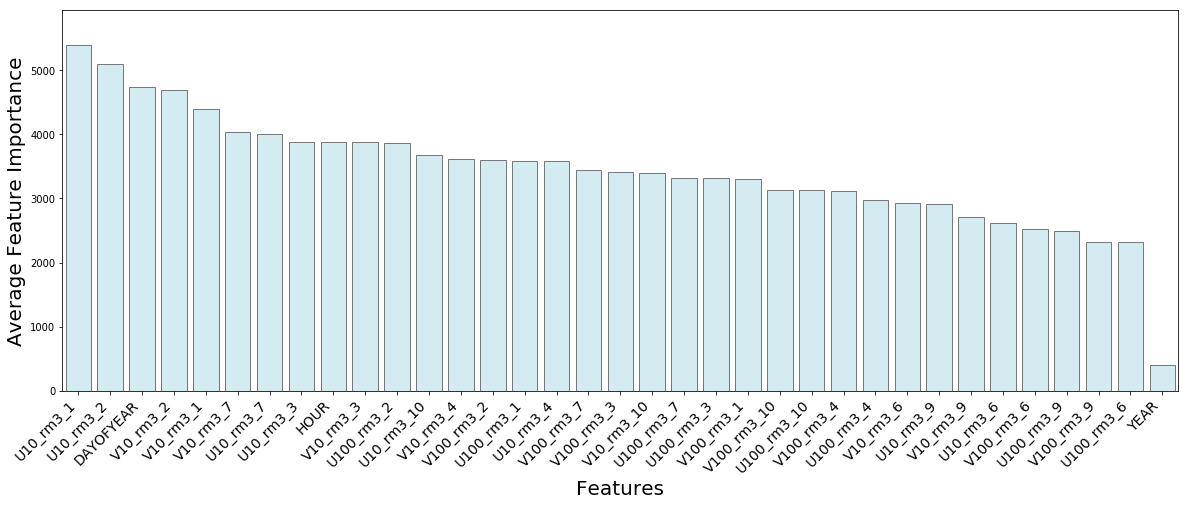

In [6]:
'''
Plot feature importances averaged over all turbines.
'''
%matplotlib inline
all_feat_imp = []
for xgb in xgbr_train_all:
    all_feat_imp.append(xgb.booster().get_score(importance_type='weight'))
all_feat_imp_df = pd.DataFrame(all_feat_imp)
feat_imp        = all_feat_imp_df.mean().sort_values(ascending=False)
n_features      = min(50,len(feat_imp))
bins            = np.arange(n_features)
x_labels        = feat_imp.index.values[:n_features]
y_values        = feat_imp.values[:n_features]
maxHeight       = 1.10*max(y_values)

fig, axes  = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axes.bar(bins, y_values, align="center", color="lightblue", edgecolor='k', alpha=0.5)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45., fontsize=14)
axes.set_xlim([-0.5,bins.size-0.5])
if len(feat_imp) <= 50:
    axes.set_xlabel('Features'.format(n_features), fontsize=20)
else:
    axes.set_xlabel('Top {0} Features'.format(n_features), fontsize=20)
axes.set_ylim([0.0, maxHeight])
axes.set_ylabel('Average Feature Importance', fontsize=20)
plt.show()
fig.savefig('XGBoost35_FeatureImportances.png', dpi=200, bbox_inches='tight')

## Refit model to entire training data set and create solution file.

<a id='Cell16'></a>

In [27]:
'''
Refit model with final settings to entire training data set and save fitted model to disk.
'''
xgbr_all = []
for target, setting in zip(targets, settings):
    xgb2 = XGBRegressor(**setting)
    %time xgb2.fit(df0[predictors], df0[target], eval_metric=["rmse"], verbose=False)
    xgbr_all.append(xgb2)
    
fName = 'xgbr_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgbr_all, path_to_file)
print('\nExtreme gradient boosting regression model saved to {0}'.format(path_to_file))

CPU times: user 21.4 s, sys: 210 ms, total: 21.6 s
Wall time: 22.5 s
CPU times: user 34.2 s, sys: 339 ms, total: 34.5 s
Wall time: 35.8 s
CPU times: user 32.8 s, sys: 171 ms, total: 33 s
Wall time: 33.2 s
CPU times: user 26.5 s, sys: 128 ms, total: 26.6 s
Wall time: 26.7 s
CPU times: user 26.1 s, sys: 121 ms, total: 26.2 s
Wall time: 26.3 s
CPU times: user 37.3 s, sys: 157 ms, total: 37.5 s
Wall time: 37.6 s
CPU times: user 30.4 s, sys: 155 ms, total: 30.6 s
Wall time: 30.8 s
CPU times: user 44.1 s, sys: 223 ms, total: 44.3 s
Wall time: 44.6 s
CPU times: user 36.8 s, sys: 261 ms, total: 37.1 s
Wall time: 37.8 s
CPU times: user 34.9 s, sys: 265 ms, total: 35.2 s
Wall time: 36.2 s

Extreme gradient boosting regression model saved to fitted_models/xgbr_2017_03_29_05_13_48.model


<a id='Cell17'></a>

In [28]:
'''
Retrieve trained model from disk. Only run this cell if previous one wasn't run.
Note that by default the file name encodes a date and time, to the second.
'''

xgbr_found = True

try:
    xgbr_all
except:
#    fName = 'xgb_2017_03_05_17_57_26' # No rolling average
#    fName = 'xgbr_2017_03_12_10_24_46' # rm=2
#    fName = 'xgbr_2017_03_10_22_09_58' # rm=3
#    fName = 'xgbr_2017_03_11_07_25_35' # rm=4
#    fName = 'xgbr_2017_03_28_07_24_58' # rm=3, dups removed
    fName = 'xgbr_2017_03_29_05_13_48' # rm=3, dups removed, (U,V,time) replaced by (H)
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbr_all = joblib.load(path_to_file)
    except:
        print('Error loading regression model from {0}\n'.format(path_to_file))
        xgbr_found = False
    else:
        print('Regression model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Fitted model already exists, not updated from file!\n')

if xgbr_found:
    for ind, xgbr in enumerate(xgbr_all):
        print('Turbine {0}:\nRegressor: {1}\n'.format(ind+1, xgbr))

Fitted model already exists, not updated from file!

Turbine 1:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.4, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

Turbine 2:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.6, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

Turbine 3:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.6, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=500, nth

<a id='Cell18'></a>

In [31]:
'''
Prepare the test data set in the same way as the training set, make predictions, and create output csv file.
'''

# Load the testing data
#TestingDataFile = "data/Test_pp_2017_03_02_15_47_36.pkl" # Without rolling average
#TestingDataFile = "data/Test_pp_2017_03_12_10_32_09.pkl" # rm=2
#TestingDataFile = "data/Test_pp_2017_03_10_15_38_00.pkl" # rm=3
#TestingDataFile = "data/Test_pp_2017_03_11_02_07_04.pkl" # rm=4
TestingDataFile = "data/Test_pp_2017_03_28_09_02_52.pkl" # rm=3, dups removed
df1             = pd.read_pickle(TestingDataFile)

# Rename dataframe columns and make lists with the new predictor labels
predictors  = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]!='ID']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
ids         = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]=='ID']
df1.columns = ids+predictors

# Count how many sets of observations we have in August and September 2013
nTotal      = len(df1)
nAugSep2013 = len([DoY for DoY in df1['DAYOFYEAR'] if DoY>212 and DoY<274])
print('\nTotal number of observation times in test set:            {0}'.format(nTotal))
print('Number of observation times in August and September 2013: {0}'.format(nAugSep2013))

# If needed, transform predictor variables to be the same as in the gamlss analysis
if gamlss:
    for i in range(0,len(wind_measurements)):
        df1[H10label[i]]  = np.sqrt(df1[U10label[i]]**2 + df1[V10label[i]]**2)
        df1[H100label[i]] = np.sqrt(df1[U100label[i]]**2 + df1[V100label[i]]**2)
    df1.drop(U10label,  1, inplace=True)
    df1.drop(U100label, 1, inplace=True)
    df1.drop(V10label,  1, inplace=True)
    df1.drop(V100label, 1, inplace=True)
    df1.drop(["YEAR", "DAYOFYEAR", "HOUR"], 1, inplace=True)
    predictors = [item for item in df1.columns.values if item[:2]!='ID']

print('\nPredictor variables: {0}'.format(predictors))

# Compute predictions
df1_ids         = []
df1_predictions = []
for ind,xgb in enumerate(xgbr_all):
    obs_id = 'ID_'+str(ind+1)
    df1_ids.extend(df1[obs_id].tolist())
    df1_predictions.extend([min(max(x,0.0),1.0) for x in xgb.predict(df1[predictors])])

# Generate output csv file
fName_out = 'data/xgbr_' + strftime("%Y_%m_%d_%H_%M_%S") + '.out.csv'
with open(fName_out, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ID","TARGETVAR"])
    for idval,yval in zip(df1_ids, df1_predictions):
        writer.writerow([idval,yval])
print('\nOutput written to {0}'.format(fName_out))


Total number of observation times in test set:            2929
Number of observation times in August and September 2013: 1464

Predictor variables: ['H10_rm3_1', 'H100_rm3_1', 'H10_rm3_2', 'H100_rm3_2', 'H10_rm3_3', 'H100_rm3_3', 'H10_rm3_4', 'H100_rm3_4', 'H10_rm3_6', 'H100_rm3_6', 'H10_rm3_7', 'H100_rm3_7', 'H10_rm3_9', 'H100_rm3_9', 'H10_rm3_10', 'H100_rm3_10']

Output written to data/xgbr_2017_03_29_05_22_41.out.csv
